In [1]:
import sys

sys.path.append('../')

In [2]:
import pandas as pd
import numpy as np

In [3]:
start_date = '2021-01-01'
end_date = '2021-08-30'

In [4]:
tic_list = ['ETH-USD']

In [5]:
tech_indicators = ['macd',
 'rsi_30',
 'cci_30',
 'rsi_6',
 'dx_30']


#tech_indicators = [
# 'open_2_sma', 
# 'rsi_6', 
# 'close_2_tema']

In [6]:
cwd = './CryptoModel/model.pkl'
reward_on_value = False
lookback_n = 3

In [7]:
from neo_finrl.data_processors.processor_yahoofinance import YahooFinanceProcessor

In [8]:
data_downloader = YahooFinanceProcessor()

### Extract historical px

In [ ]:
stock_history_df = data_downloader.download_data(start_date, end_date, tic_list, '1D')

In [ ]:
data_downloader.time_interval = '1D'
stock_history_df = data_downloader.clean_data(stock_history_df)

In [ ]:
stock_history_df = data_downloader.add_technical_indicator(stock_history_df, tech_indicators)

In [ ]:
stock_history_df.to_csv('./ETH_hist.csv', index = False)

### Env module

In [9]:
from test_env.single_crypto_env import CryptoTradingEnv

### Setup env

In [10]:
stock_history_df = pd.read_csv('./ETH_hist.csv')
# to prevent policy_vl = nan
stock_history_df.fillna(1e-10, inplace = True)

In [11]:
price_array = stock_history_df[['open', 'adjcp', 'low', 'high']].values
tech_array = stock_history_df[tech_indicators].values

In [12]:
train_test_split_index = int(stock_history_df.shape[0] * 0.8)

In [13]:
print (f'{train_test_split_index} records for training')
print (f'{stock_history_df.shape[0] - train_test_split_index} records for testing')

193 records for training
49 records for testing


In [14]:
config = dict()

config['price_array'] = price_array[:train_test_split_index]
config['tech_array'] = tech_array[:train_test_split_index]
config['if_train'] = True
config['if_value'] = reward_on_value
config['lookback_n'] = lookback_n

initial_capital = 1e-5
initial_stocks = np.array([40.0])
max_step = 30

In [15]:
crypto_env = CryptoTradingEnv(config, 
                              initial_capital=initial_capital,
                              initial_stocks=initial_stocks,
                              max_step = max_step, 
                              )

### Train RL

In [16]:
from stable_baselines3 import PPO, DDPG
from stable_baselines3.common.vec_env import DummyVecEnv, VecCheckNan, VecNormalize
from stable_baselines3.common.logger import configure

In [17]:
tmp_path = "./tmp/sb3_log/"
# set up logger
new_logger = configure(tmp_path, ["stdout", "csv"])

Logging to ./tmp/sb3_log/


In [18]:
env_train = DummyVecEnv([lambda : crypto_env])
env_train = VecCheckNan(env_train, raise_exception=True)
#env_train = VecNormalize(env_train)

model_name = 'ppo'

if model_name == 'ppo':
    model = PPO("MlpPolicy", env_train, learning_rate=0.00025, 
                            n_steps=1024, batch_size=128, ent_coef=0.0, 
                            gamma=0.99, seed=312, verbose = 1)
elif model_name == 'ddpg':
    model = DDPG("MlpPolicy", env_train, learning_rate=0.00025, 
                 batch_size=128, gamma = 0.99, seed=312)
    
model.set_logger(new_logger)

Using cuda device


In [19]:
model.learn(total_timesteps=5e4, tb_log_name = 'ppo', log_interval=10)
print('Training finished!')

----------------------------------------
| time/                   |            |
|    fps                  | 797        |
|    iterations           | 10         |
|    time_elapsed         | 12         |
|    total_timesteps      | 10240      |
| train/                  |            |
|    approx_kl            | 0.00462192 |
|    clip_fraction        | 0.0346     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.4       |
|    explained_variance   | -1.52      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.00356    |
|    n_updates            | 90         |
|    policy_gradient_loss | -0.00425   |
|    std                  | 0.976      |
|    value_loss           | 0.000273   |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 772          |
|    iterations           | 20           |
|    time_elapsed         | 26           |
|    t

In [20]:
model.save(cwd)
print('Trained model saved in ' + str(cwd))

Trained model saved in ./CryptoModel/model.pkl


### Test RL

In [21]:
#test on the testing env
def testRun(model, env_instance):
    state = env_instance.reset()
    episode_returns = list()  # the cumulative_return / initial_account
    done = False

    while not done:
        action = model.predict(state)[0]
        #print (action)
        state, reward, done, _ = env_instance.step(action)
        
        #print (env_instance.stocks)
        #total_asset = env_instance.amount + (env_instance.price_ary[env_instance.day + env_instance.run_index, 1] \
        #                                     * env_instance.stocks).sum()
        #episode_return = total_asset / env_instance.initial_total_asset
        
        episode_returns.append(env_instance.total_asset)
        
    print('Test Finished!')  
    return episode_returns

In [34]:
test_config = dict()

start_idx = train_test_split_index
start_idx = 120
test_config['price_array'] = price_array[start_idx:]
test_config['tech_array'] = tech_array[start_idx:]
test_config['if_train'] = False
test_config['if_value'] = reward_on_value
test_config['lookback_n'] = lookback_n

max_step = min(test_config['price_array'].shape[0], 30)

In [35]:
#test_env = CryptoTradingEnv(test_config, \
#                            initial_capital=1e4, \
#                            initial_stocks = np.array([0.00001]), \
#                            max_step = max_step)

test_env = CryptoTradingEnv(test_config, \
                            initial_capital=0, \
                            max_step = max_step, \
                           initial_stocks = np.array([20.0]))

test_model = PPO.load(cwd)
#test_model = model
test_model = test_model.policy.eval()

In [36]:
cumulative_return = testRun(test_model, test_env)

if test_config['if_value']:
    holding_return = price_array[start_idx + max_step, 1] / price_array[start_idx, 1]
else:
    holding_return = 1.0

print ("Holding-strategy return: ", holding_return)

initial stock: [20.] inital amount:  0
initial asset:  20.0
[Day 1] BUY: 0.0
[Day 4] BUY: 0.0
[Day 5] BUY: 0.0
[Day 7] BUY: 0.0
[Day 8] SELL: 10.5154
[Day 10] BUY: 9.3359
[Day 11] BUY: 0.0
[Day 12] BUY: 0.0
[Day 13] SELL: 13.39
[Day 14] BUY: 14.100900000000001
[Day 15] BUY: 0.0
[Day 16] BUY: 0.0
[Day 18] BUY: 0.0
[Day 19] SELL: 19.5313
[Day 20] BUY: 22.206300000000002
[Day 21] BUY: 0.0
[Day 23] BUY: 0.0
[Day 24] BUY: 0.0
[Day 26] BUY: 0.0
[Day 27] BUY: 0.0
[Day 30] BUY: 0.0
Episode Return:  1.1103199
Test Finished!
Holding-strategy return:  1.0


In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 0, 'time')

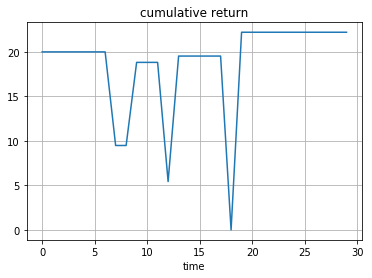

In [38]:
plt.plot(cumulative_return, label='agent return')
plt.grid()
plt.title('cumulative return')
plt.xlabel('time')

Text(0.5, 0, 'time')

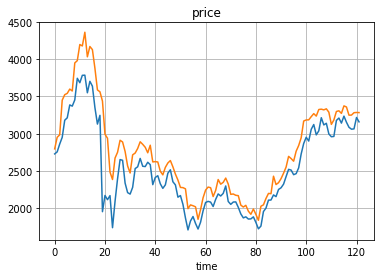

In [39]:
plt.plot(test_config['price_array'][:, 2:4], label='px')
plt.grid()
plt.title('price')
plt.xlabel('time')